# Imports

Import the wheel containinf the parser class.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from sklearn.preprocessing import power_transform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from utils.fetcher import Fetcher as f
from utils.museum import Museum
from enricher import Enricher as e

# Fetch the Dataframe Using the Parser Class
The parser will fetch a collection of Wikipedia data and dump it into a Dataframe for easier use by a Data Scientist. Once this step is completed there no further use for the parser.

The ```fetch_museum_data method``` will take a ```minimum_visitors``` argument that filters the list of museums returned (to those with a visitors value meeting or exceeding the parameter value).  Use this to scope the query.

NOTE: This is a relatively slow process - since the parser is crawling the Wikipedia page's museum and city links.  

In [1]:
from museum_data_compiler import MuseumParser

parser = MuseumParser()
# museum_df = parser.fetch_museum_data()

# Or ... Fetch the Dataframe From a CSV Compiled Previously
The 'run_job' script in the Parser container runs the code in the cell above and dumps the CVS to a file on disk.  To speed things up a bit we can just relaod a previoulsy parsed set of Wikipedia data.

In [4]:
filename = '../data/museum_data_265377.csv'
museum_df = pd.read_csv(filename, sep='\t')

In [5]:
museum_df.head()

,Unnamed: 0,name,wiki,city,city_wiki,country,country_wiki,visitors,city_population,urban_population,longitude,latitude,museum_type
0,0,Louvre,Louvre,Paris,Paris,France,France,7726321,2102650,10858852.0,NaN,NaN,Art museum and historic site
1,1,Vatican Museums,Vatican_Museums,Vatican City,Vatican_City,Vatican City,Vatican_City,5080866,764,NaN,41.90639,12.45444,Art museum
2,2,Natural History Museum,"Natural_History_Museum,_London",London,London,United Kingdom,United_Kingdom,4654608,8799800,9787426.0,51.49611,-0.17639,Natural history museum
3,3,British Museum,British_Museum,London,London,United Kingdom,United_Kingdom,4097253,8799800,9787426.0,NaN,NaN,NaN
4,4,National Museum of Natural History,National_Museum_of_Natural_History,"Washington, D.C.","Washington,_D.C.",United States,United_States,3900000,689545,5174759.0,38.89130,-77.02590,Natural History


In [6]:
museum_df.describe()

,Unnamed: 0,visitors,city_population,urban_population,longitude,latitude
count,71.000000,7.100000e+01,7.100000e+01,5.200000e+01,50.000000,50.000000
mean,35.000000,2.141153e+06,7.093538e+06,1.129714e+07,37.280711,41.168280
std,20.639767,1.105750e+06,6.582651e+06,9.981719e+06,15.908737,77.124821
min,0.000000,1.251030e+06,7.640000e+02,5.309900e+05,-37.822500,-118.285830
25%,17.500000,1.422890e+06,2.102650e+06,5.103660e+06,30.828537,-0.175973
50%,35.000000,1.694000e+06,5.278121e+06,9.787426e+06,38.891345,18.142838
75%,52.500000,2.413492e+06,9.659322e+06,1.425437e+07,48.695950,119.500524
max,70.000000,7.726321e+06,2.687550e+07,3.910500e+07,59.938742,144.968890


In [7]:
# We don't need these.
museum_df = museum_df.drop(columns=['Unnamed: 0', 'wiki', 'city_wiki', 'country_wiki'])

In [8]:
# Filter data set to desired subset
museum_df = museum_df[museum_df.visitors >= 2000000]

### Check our 'primary' independent.

<Axes: >

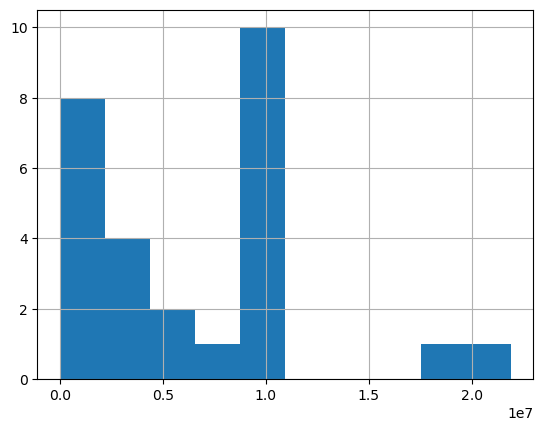

In [9]:
museum_df['city_population'].hist(bins=10)

Terrible.

<Axes: >

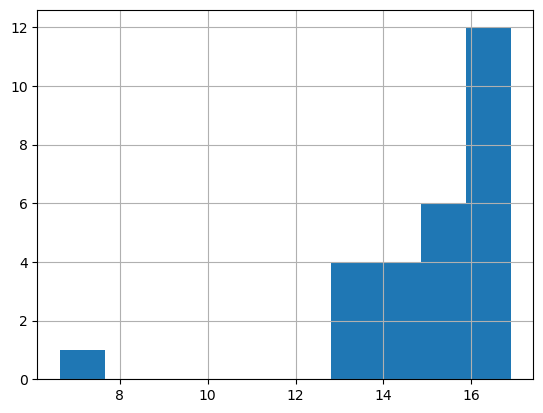

In [10]:
museum_df['log_city_population'] = np.log(museum_df['city_population'])
museum_df['log_city_population'].hist(bins=10)

Still terrible.

### Vatican City
Vatican City is causing us some problems.  Manually address this by updating the city population value to that of Rome. 2,860,009 according to Wikipedia

array([[<Axes: title={'center': 'city_population'}>,
        <Axes: title={'center': 'log_city_population'}>],
       [<Axes: title={'center': 'yj_city_population'}>,
        <Axes: title={'center': 'bc_city_population'}>]], dtype=object)

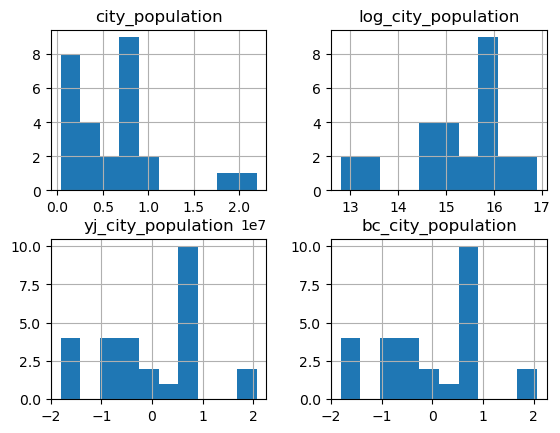

In [11]:
museum_df.loc[museum_df['name']=='Vatican Museums', 'city_population'] = 2860009
museum_df['log_city_population'] = np.log(museum_df['city_population'])
museum_df['yj_city_population'] = power_transform(np.array(museum_df['city_population']).reshape(-1, 1), method='yeo-johnson', standardize=True)
museum_df['bc_city_population'] = power_transform(np.array(museum_df['city_population']).reshape(-1, 1), method='box-cox', standardize=True)

museum_df.hist(column=['city_population', 'log_city_population', 'yj_city_population', 'bc_city_population'], bins=10)

Some marginally better options.

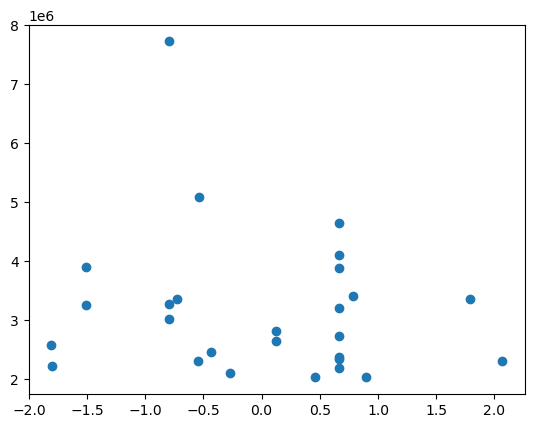

In [12]:
plt.scatter(museum_df['yj_city_population'], museum_df['visitors'])

### Add a 'museums in city' feature

array([[<Axes: title={'center': 'museums_in_city'}>,
        <Axes: title={'center': 'log_museums_in_city'}>],
       [<Axes: title={'center': 'yj_museums_in_city'}>,
        <Axes: title={'center': 'bc_museums_in_city'}>]], dtype=object)

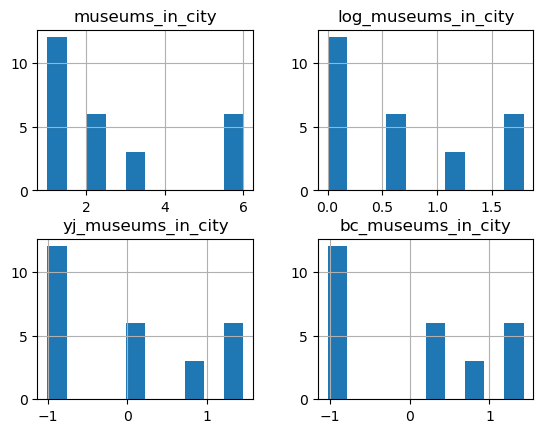

In [13]:
museum_df['museums_in_city'] = museum_df['name'].groupby(museum_df['city']).transform('count')

museum_df['log_museums_in_city'] = np.log(museum_df['museums_in_city'])
museum_df['yj_museums_in_city'] = power_transform(np.array(museum_df['museums_in_city']).reshape(-1, 1), method='yeo-johnson', standardize=True)
museum_df['bc_museums_in_city'] = power_transform(np.array(museum_df['museums_in_city']).reshape(-1, 1), method='box-cox', standardize=True)

museum_df.hist(column=['museums_in_city', 'log_museums_in_city', 'yj_museums_in_city', 'bc_museums_in_city'])

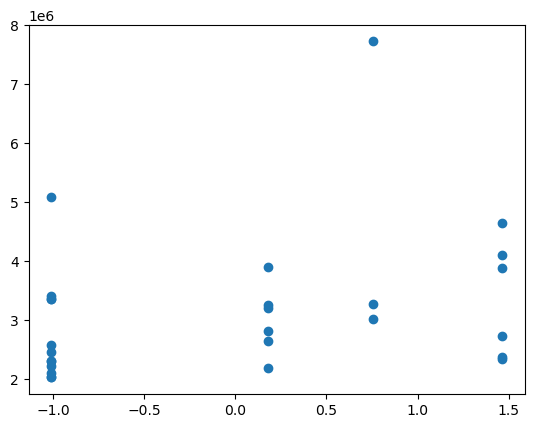

In [14]:
plt.scatter(museum_df['yj_museums_in_city'], museum_df['visitors'])

# Setup a basic (univariate) Linear Regression

Oversample the entire set to address our variance problem

In [16]:
# oversample_df = museum_df[~museum_df.name.isin(['Louvre']) & ~museum_df.country.isin(['China'])]
oversample_df = museum_df.sample(n=1500, replace=True, random_state=13)

In [17]:
X = np.array(oversample_df['log_city_population']).reshape(-1, 1)
y = np.array(oversample_df['visitors']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.014716578842200012

In [19]:
print(model.intercept_, model.coef_, model.score(X, y))

[4688030.06205888] [[-103794.12523444]] 0.01204668645135798


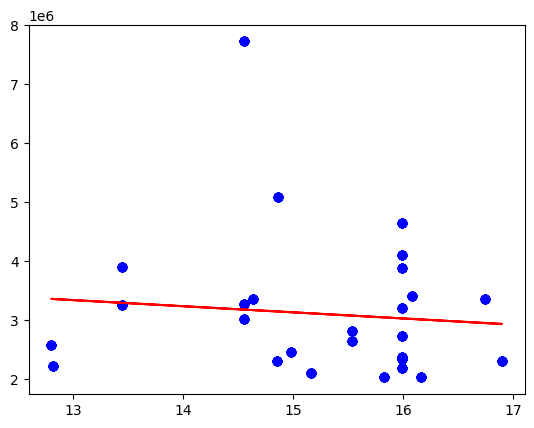

In [20]:
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, color ='b')

plt.plot(X_test, y_pred, color ='r')

plt.show()

In [21]:
pd.get_dummies(museum_df, columns = ['country'])
# Clean the dataframe up a bit to focus on country as a second independent.
copy_df = oversample_df.drop(columns=[
    'name', 
    'city', 
    'country', 
    'city_population', 
    'urban_population', 
    'longitude', 
    'latitude', 
    'museum_type', 
    'log_city_population', 
    'bc_city_population', 
    'museums_in_city', 
    'log_museums_in_city',
    'yj_museums_in_city', 
    'bc_museums_in_city'
])

In [22]:
X = copy_df.drop('visitors',axis= 1) 
y = copy_df['visitors'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.016875167987745576

In [24]:
print(model.intercept_, model.coef_, model.score(X, y))

3084511.7739670584 [-164638.89170245] 0.021587698947670986
